In [14]:
import pennylane as qml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from numba import jit, prange

In [15]:
def plot_results(accepted_states_int, rejected_states_int, accepted_energies, rejected_energies, num_qubits):

    fig, axs = plt.subplots(4, 2, figsize=(15, 20))

    # Plot accepted states
    axs[0, 0].plot(range(len(accepted_states_int)), accepted_states_int)
    axs[0, 0].set(xlabel='Step', ylabel='Accepted States', title='Accepted States')

    # Plot accepted energies
    axs[0, 1].plot(range(len(accepted_energies)), accepted_energies)
    axs[0, 1].set(xlabel='Step', ylabel='Energy', title='Accepted Energies')

    # Plot rejected states
    axs[1, 0].plot(range(len(rejected_states_int)), rejected_states_int)
    axs[1, 0].set(xlabel='Step', ylabel='Rejected States', title='Rejected States')

    # Plot rejected energies
    axs[1, 1].plot(range(len(rejected_states_int)), rejected_energies)
    axs[1, 1].set(xlabel='Step', ylabel='Energy', title='Rejected Energies')

    # Plot histogram of accepted states
    axs[2, 0].hist(accepted_states_int, bins=2**num_qubits)
    axs[2, 0].set(xlabel='Accepted States', ylabel='Frequency', title='Histogram of Accepted States')

    # Plot histogram of rejected states
    axs[2, 1].hist(rejected_states_int, bins=2**num_qubits)
    axs[2, 1].set(xlabel='Rejected States', ylabel='Frequency', title='Histogram of Rejected States')

    # Plot histogram of accepted states energies
    axs[3, 0].hist(accepted_energies, bins=2**num_qubits)
    axs[3, 0].set(xlabel='Energy', ylabel='Frequency', title='Histogram of Accepted States Energies')

    # Plot histogram of rejected states energies
    axs[3, 1].hist(rejected_energies, bins=2**num_qubits)
    axs[3, 1].set(xlabel='Energy', ylabel='Frequency', title='Histogram of Rejected States Energies')

    # Adjust the space between plots
    plt.tight_layout()
    plt.show()

In [16]:
def compute_hamming_distance(state1, state2):
    """
    This function computes the Hamming distance between two binary states.

    Args:
        state1 (array): The first binary state.
        state2 (array): The second binary state.

    Returns:
        int: The Hamming distance between the two states.
    """
    return np.sum(state1 != state2)


In [17]:
def make_markov_chain(accepted_states_int, num_qubits):
    """
    This function creates a Markov chain from a sequence of accepted states and visualizes it as a directed graph.

    Parameters:
    accepted_states_int: A list of accepted states from the Quantum Metropolis-Hastings algorithm. Each state is represented as an integer.
    num_qubits: The number of qubits (spins) in the system.

    Outputs:
    A plot of the Markov chain as a directed graph. Each node represents a state, and each edge represents a transition between states. The weight of an edge is the probability of the transition.
    """

    # Convert the list of accepted states to a numpy array for easier manipulation
    accepted_states_array = np.array(accepted_states_int)

    # Create a transition matrix of size (2**num_qubits, 2**num_qubits) initialized with zeros
    # This matrix will store the number of transitions between each pair of states
    transition_matrix = np.zeros((2**num_qubits, 2**num_qubits))

    # Loop over each accepted state (except the last one)
    for i in range(len(accepted_states_array) - 1):
        # Get the current state and the next state
        current_state = accepted_states_array[i]
        next_state = accepted_states_array[i + 1]

        # Increment the corresponding entry in the transition matrix
        transition_matrix[current_state, next_state] += 1

    # Normalize the transition matrix by dividing each row by its sum
    # This converts the counts of transitions into probabilities
    transition_matrix_normalized = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

    # Create a directed graph using NetworkX
    # This graph will represent the Markov chain
    G = nx.DiGraph()

    # Loop over each non-zero entry in the transition matrix
    for i, row in enumerate(transition_matrix_normalized):
        for j, weight in enumerate(row):
            if weight != 0:
                # Add an edge from the current state to the next state with the normalized weight
                # The weight represents the probability of the transition
                G.add_edge(i, j, weight=weight)

    # Plot the graph in the style of a Markov chain
    # The nodes represent states, and the edges represent transitions between states
    # The labels on the edges represent the probabilities of the transitions
    pos = nx.circular_layout(G)
    labels = {state: str(state) for state in G.nodes()}
    edge_labels = {(u, v): f"{weight:.2f}" for u, v, weight in G.edges(data='weight')}
    nx.draw_networkx(G, pos, labels=labels, node_color='lightblue', node_size=50, font_size=10, edge_color='gray')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title("Markov Chain Transition Graph")
    plt.axis('off')
    plt.show()

In [18]:
def compute_and_plot_stationary_distribution(accepted_states_int, num_qubits):
    """
    Computes and plots the stationary distribution of a Markov chain.

    Args:
        accepted_states_int (array): An array of accepted states represented as integers.
        num_qubits (int): The number of qubits in the system.

    Returns:
        None
    """
    # Compute the unique states and their counts
    # np.unique returns the sorted unique elements of an array and their counts
    unique_states, state_counts = np.unique(accepted_states_int, return_counts=True)

    # Initialize a transition matrix with zeros
    # The size of the matrix is (2**num_qubits, 2**num_qubits) because there are 2**num_qubits possible states
    transition_matrix = np.zeros((2**num_qubits, 2**num_qubits))

    # Loop over each unique state
    for i, state in enumerate(unique_states):
        # Find the indices where the current state appears in the accepted_states_int array
        # np.where returns the indices of elements in an array that satisfy a condition
        indices = np.where(accepted_states_int == state)[0]

        # Compute the transition probabilities from the current state to other states
        for j in range(len(indices) - 1):
            # If we are at the last index, break the loop to avoid index out of range error
            if j == len(indices) - 1:
                break
            # Get the current state and the next state from the accepted_states_int array
            current_state = accepted_states_int[indices[j]]
            next_state = accepted_states_int[indices[j]+1]
            # Increment the corresponding entry in the transition matrix
            transition_matrix[state, next_state] += 1

    # Normalize the transition probabilities
    # Divide each row of the transition matrix by its sum to get probabilities
    transition_matrix /= np.sum(transition_matrix, axis=1, keepdims=True)
    # Replace any NaN values with zero
    transition_matrix = np.nan_to_num(transition_matrix)

    # Compute the eigenvalues of the transition matrix
    # Eigenvalues are used to analyze the behavior of the system described by the transition matrix
    # compute left eigen vectors

    eigenvalues, eigenvectors = np.linalg.eig(transition_matrix)

    eigenvalues_T, eigenvectors_T = np.linalg.eig(transition_matrix.T)

    leading_evec_norm = eigenvectors[:,0] / eigenvectors[:,0][0]
    leading_evec_T_norm = eigenvectors_T[:,0] / np.sum(eigenvectors_T[:,0])

    print("Eigenvalues: ", *zip(eigenvalues,eigenvalues_T),sep="\n")
    print("Eigenvector Leading: ", leading_evec_norm, leading_evec_T_norm,sep="\n")
    # print("Eigenvector Leading 2: ", eigenvectors[:,1], eigenvectors_T[:,1],sep="\n")


    # Plot the eigenvalues
    plt.plot(range(len(eigenvalues)), eigenvalues)
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
    plt.title('Eigenvalues')
    plt.show()

    # # Plot the first eigenvector

    plt.plot(range(len(eigenvectors[:,0])), leading_evec_norm)
    plt.xlabel('Index')
    plt.ylabel('Evec')
    plt.title(' Evec 1')
    plt.show()

    plt.plot(range(len(eigenvectors_T[:,0])), leading_evec_T_norm)
    plt.xlabel('Index')
    plt.ylabel('Evec T')
    plt.title('Evec T 1')
    plt.show()

    # plt.plot(range(len(eigenvectors[:,0])), eigenvectors[:,0])
    # plt.xlabel('Index')
    # plt.ylabel('Evec')
    # plt.title('Evec 2')
    # plt.show()

    # plt.plot(range(len(eigenvectors_T[:,0])), eigenvectors_T[:,0])
    # plt.xlabel('Index')
    # plt.ylabel('Evec T')
    # plt.title('Evec T 2')
    # plt.show()



    # plt.plot(range(len(eigenvectors[0])), eigenvectors[0])
    # plt.xlabel('Index')
    # plt.ylabel('Evec')
    # plt.title('Evec')
    # plt.show()


    plt.tight_layout()
    plt.show()

    return transition_matrix

# Quantum Metropolis Hastings

In [29]:
# Number of qubits in the system
num_qubits = 4

# Define a quantum device with n qubits
dev = qml.device('default.qubit', wires=num_qubits, shots=1)

def get_ising_hamiltonian(J, h, num_qubits):
    """
    This function generates the Ising model Hamiltonian for a given number of qubits, coupling strengths, and magnetic field strengths.

    Parameters:
    J (numpy.ndarray): A 2D array representing the coupling strengths between different qubits.
    h (numpy.ndarray): A 1D array representing the magnetic field strengths applied to each qubit.
    num_qubits (int): The number of qubits in the system.

    Returns:
    pennylane.operation.Observable: The Ising model Hamiltonian as a PennyLane observable.
    """

    # Initialize an empty list to store the terms in the Hamiltonian
    obs = []

    # Loop over each qubit in the system
    for i in range(num_qubits):
        # For each qubit, add a term to the Hamiltonian representing the effect of the magnetic field on that qubit.
        # This is done by applying the Pauli Z operator to the qubit and multiplying it by the magnetic field strength for that qubit.
        obs.append(qml.PauliZ(i) * h[i])

    # Loop over each pair of qubits in the system
    for i in range(num_qubits):
        for j in range(num_qubits):
            # For each pair of qubits, add a term to the Hamiltonian representing the interaction between the two qubits.
            # This is done by applying the Pauli Z operator to both qubits, taking the tensor product of the two operators, and multiplying it by the coupling strength between the two qubits.
            # We only add the term if i != j to avoid self-interactions.
            if i != j:
                obs.append(qml.PauliZ(i) @ qml.PauliZ(j) * J[i, j])

    # The Hamiltonian is the sum of all the terms we added to the list.
    # We use the sum() function to add together all the terms in the list and return the result.
    return sum(obs)



@qml.qnode(dev)
def T_S_evolution_error_free(initial_state, num_qubits, R, a, b, theta):
    """
    This function defines a quantum circuit for T_S evolution without errors. It uses the PennyLane library to define the quantum circuit.

    Args:
        initial_state (array): The initial state of the qubits. This should be a 1D array of length num_qubits.
        num_qubits (int): The number of qubits in the system.
        R (int): The number of iterations to perform the T_S evolution.
        a (array): The parameters for the RX gates. This should be a 1D array of length num_qubits.
        b (array): The parameters for the RZ gates. This should be a 1D array of length num_qubits.
        theta (array): The parameters for the RZ gates between CNOT gates. This should be a 2D array of size num_qubits x num_qubits.

    Returns:
        array: The measurement results of the PauliZ operators on all qubits. This is a 1D array of length num_qubits.
    """

    # Apply the initial state to the qubits using the BasisEmbedding operation.
    # This operation sets the state of each qubit to the corresponding element of the initial_state array.
    qml.BasisEmbedding(initial_state, wires=range(num_qubits))

    # Perform the T_S evolution for R iterations.
    for r in range(R):
        # Apply RX and RZ gates to the first half of the qubits.
        # The parameters for the gates are taken from the a and b arrays.
        for w in range(num_qubits//2):
            qml.RX(2*a[w], wires=w)
            qml.RZ(2*b[w], wires=w)

        # Apply a sequence of CNOT and RZ gates to pairs of qubits.
        # The pairs of qubits are chosen such that the first qubit in each pair is even and the second qubit is the next one in the sequence.
        for w in range(num_qubits//2):
            qml.CNOT(wires=[2*w, 2*w+1])
            qml.RZ(theta[2*w, 2*w+1], wires=2*w+1)
            qml.CNOT(wires=[2*w, 2*w+1])

        # Apply a sequence of CNOT and RZ gates to pairs of qubits.
        # The pairs of qubits are chosen such that the first qubit in each pair is odd and the second qubit is the next one in the sequence.
        for w in range(num_qubits//2):
            qml.CNOT(wires=[(2*w+1) % num_qubits, (2*w+2) % num_qubits])
            qml.RZ(theta[(2*w+1) % num_qubits, (2*w+2) % num_qubits], wires=(2*w+2) % num_qubits)
            qml.CNOT(wires=[(2*w+1) % num_qubits, (2*w+2) % num_qubits])

        # Apply RX and RZ gates to all the qubits.
        # The parameters for the gates are taken from the a and b arrays.
        for w in range(num_qubits):
            qml.RX(2*a[w], wires=w)
            qml.RZ(2*b[w], wires=w)

    # Measure the state of all qubits using the PauliZ operator.
    # The measurement results are returned as a 1D array.
    return [qml.sample(qml.PauliZ(i)) for i in range(num_qubits)]


@qml.qnode(dev)
def H_energy(initial_state, H, num_qubits):
    """
    This function defines a quantum circuit that measures the expectation value of a given Hamiltonian H on a given initial state. It uses the PennyLane library to define the quantum circuit.

    Args:
        initial_state (array): The initial state of the qubits. This should be a 1D array of length num_qubits.
        H (qml.Hamiltonian): The Hamiltonian whose expectation value is to be measured.
        num_qubits (int): The number of qubits in the system.

    Returns:
        float: The expectation value of the Hamiltonian H on the initial state.
    """

    # Apply the initial state to the qubits using the BasisEmbedding operation.
    # This operation sets the state of each qubit to the corresponding element of the initial_state array.
    qml.BasisEmbedding(initial_state, wires=range(num_qubits))

    # Measure the expectation value of the Hamiltonian H on the current state of the qubits.
    # The expectation value is a single number that gives the average result of measuring the Hamiltonian on the state many times.
    return qml.expval(H)

In [30]:
def compute_scaled_energy_difference(state1, state2, H, num_qubits, beta):
    """
    This function computes the scaled difference in energy between two states under a given Hamiltonian. The energy difference is scaled by a factor of e^(-beta*|energy difference|), where beta is a parameter representing the inverse temperature.

    Args:
        state1 (array): The first state. This should be a 1D array of length num_qubits.
        state2 (array): The second state. This should be a 1D array of length num_qubits.
        H (qml.Hamiltonian): The Hamiltonian under which the energy of the states is to be calculated.
        num_qubits (int): The number of qubits in the system.
        beta (float): The inverse temperature parameter used to scale the energy difference.

    Returns:
        float: The scaled difference in energy between state1 and state2 under the Hamiltonian H.
    """

    # Compute the energy of state1 under the Hamiltonian H
    energy_1 = H_energy(state1, H, num_qubits)

    # Compute the energy of state2 under the Hamiltonian H
    energy_2 = H_energy(state2, H, num_qubits)

    # Compute the absolute difference in energy between the two states
    energy_difference = energy_2 - energy_1

    # Scale the energy difference by a factor of e^(-beta*energy difference)
    scaled_energy_difference = np.exp(energy_difference * beta)

    # Return the scaled energy difference
    return scaled_energy_difference

In [31]:
def map_values(input_value):
    """
    This function maps -1 to 1, 1 to 0, and returns "Invalid input" for any other input.

    Args:
        input_value (int): The value to be mapped.

    Returns:
        int or str: The mapped value if input is -1 or 1, "Invalid input" otherwise.
    """
    # If the input value is -1, return 1
    if input_value == -1:
        return 1
    # If the input value is 1, return 0
    elif input_value == 1:
        return 0
    # If the input value is anything else, return "Invalid input"
    else:
        return "Invalid input"

# np.vectorize is a function that takes a function as input and returns a new function that can apply the input function element-wise to arrays.
# Here, we use np.vectorize to create a new function vmap_values that can apply the map_values function to arrays.
vmap_values = np.vectorize(map_values)

In [32]:
def binary_to_int(binary_array):
    """
    This function converts a binary array to an integer.

    Args:
        binary_array (array): The binary array to be converted. This should be a 1D array of 0s and 1s.

    Returns:
        int: The integer representation of the binary array.
    """

    # Convert the binary array to a string.
    # The map function applies the str function to each element of the binary_array, converting each element to a string.
    # The ''.join function concatenates all the string elements into a single string.
    binary_str = ''.join(map(str, binary_array))

    # Convert the binary string to an integer.
    # The int function takes a string and the base of the number system (2 for binary) and returns the integer representation of the string.
    return int(binary_str, 2)

In [33]:
def quantum_metropolis_hastings(initial_state, num_steps, H, num_qubits, beta, R, a, b, theta):
    """
    This function performs the Metropolis-Hastings algorithm for a quantum system. It starts from an initial state and performs a given number of steps. At each step, it proposes a new state and decides whether to accept or reject it based on the Metropolis-Hastings acceptance probability.

    Args:
        initial_state (array): The initial state of the qubits. This should be a 1D array of length num_qubits.
        num_steps (int): The number of steps to perform in the Metropolis-Hastings algorithm.
        H (qml.Hamiltonian): The Hamiltonian of the system.
        num_qubits (int): The number of qubits in the system.
        beta (float): The inverse temperature parameter used in the Metropolis-Hastings acceptance probability.
        R (int): The number of iterations to perform the T_S evolution.
        a (array): The parameters for the RX gates. This should be a 1D array of length num_qubits.
        b (array): The parameters for the RZ gates. This should be a 1D array of length num_qubits.
        theta (array): The parameters for the RZ gates between CNOT gates. This should be a 2D array of size num_qubits x num_qubits.

    Returns:
        list: A list of accepted states.
        list: A list of rejected states.
        list: A list of energies of the accepted states.
        list: A list of energies of the rejected states.
    """

    # Initialize the current state to the initial state
    current_state = initial_state

    # Initialize lists to store the accepted and rejected states and their energies
    accepted_states = []
    rejected_states = []
    accepted_energies = []
    rejected_energies = []
    # Initialize a list to store the changes in the accepted energies
    accepted_energy_changes = []

    # Perform the Metropolis-Hastings algorithm for the specified number of steps
    for step in range(num_steps):
        # Propose a new state by performing a T_S evolution on the current state
        proposed_state = vmap_values(np.array(T_S_evolution_error_free(initial_state, num_qubits, R, a, b, theta)))

        # Compute the scaled difference in energy between the current state and the proposed state
        scaled_energy_diff = compute_scaled_energy_difference(current_state, proposed_state, H, num_qubits, beta)

        # Compute the Metropolis-Hastings acceptance probability
        acceptance_prob = min(1, scaled_energy_diff)


        # Compute the energy of the proposed state
        proposed_energy = H_energy(proposed_state, H, num_qubits)

        # Current energy
        current_energy = H_energy(current_state, H, num_qubits)

        # Decide whether to accept or reject the proposed state
        if np.random.rand() < acceptance_prob:
            # If the proposed state is accepted, update the current state and add the proposed state and its energy to the lists of accepted states and energies
            current_state = proposed_state
            accepted_states.append(proposed_state)
            accepted_energies.append(proposed_energy)

            # If this is not the first accepted state, compute the change in energy and add it to the list of energy changes
            if accepted_energies:
                energy_change = proposed_energy - accepted_energies[-1]
                accepted_energy_changes.append(energy_change)
        else:
            # If the proposed state is rejected, add the proposed state and its energy to the lists of rejected states and energies
            rejected_states.append(proposed_state)
            rejected_energies.append(proposed_energy)
            accepted_states.append(np.array(current_state))
            accepted_energies.append(np.array(current_energy))

    # Return the lists of accepted and rejected states and their energies
    return accepted_states, rejected_states, accepted_energies, rejected_energies, accepted_energy_changes

## Ensemble trials

In [25]:
num_steps = 5000

# Initialize the initial state to be the ground state of the first qubit
initial_state = np.zeros(num_qubits)
initial_state[0] = 1

# # Randomly initialize the coupling strengths for the Ising model
# J = (np.random.rand(num_qubits, num_qubits) - 0.5)*2

# Randomly initialize the magnetic field strengths for the Ising model
h = np.random.normal(0, 1, num_qubits)

J = np.zeros((num_qubits, num_qubits))
for i in range(num_qubits):
        J[i, (i+1) % num_qubits] = np.random.normal(0, 1)

H = get_ising_hamiltonian(J, h, num_qubits)



# Set the number of steps and the temperature for the Metropolis-Hastings algorithm
R = 4
# w = 2
# beta = 0.1

results_dict = {}

temperatures = [1,5,10]#[0.1, 0.3, 0.5, 1, 2, 3, 5, 10, 30, 50, 100, 200, 500, 1000] #[1, 5, 10]

for T in temperatures:
        print('The current temperature is :', T)
        alpha = 1/np.sqrt(2)
        # GAMMA = range(0.26,0.6,10)
        dt = np.random.uniform(2,20)/R
        gamma = np.random.uniform(0.25,0.6)
        a = np.ones(num_qubits) * gamma * dt
        b = - np.ones(num_qubits) * (1 - gamma) * alpha * h * dt
        # Randomly initialize parameters for the interaction terms in the Hamiltonian
        theta = -2*(1-gamma)*alpha*J
        beta = 1/T
        accepted_states, rejected_states, accepted_energies, rejected_energies, accepted_energy_changes = quantum_metropolis_hastings(initial_state, num_steps, H, num_qubits, beta, R, a, b, theta)
        results_dict.update({T : {'accepted_states': accepted_states, 'rejected_states': rejected_states, 'accepted_energies': accepted_energies, 'rejected_energies': rejected_energies, 'accepted_energy_changes': accepted_energy_changes}})
        # accepted_states = results_dict[T]['accepted_states']
        # rejected_states = results_dict[T]['rejected_states']
        # accepted_states_int = [binary_to_int(state) for state in accepted_states]
        # rejected_states_int = [binary_to_int(state) for state in rejected_states]
        # accepted_energies = results_dict[T]['accepted_energies']
        # rejected_energies = results_dict[T]['rejected_energies']
        # accepted_energy_changes = results_dict[T]['accepted_energy_changes']
        # print(f'Temperature: {T}')
        # print(f'Number of accepted states: {len(accepted_states)}')
        # print(f'Number of rejected states: {len(rejected_states)}')
        # print(f'Average energy change for accepted states: {np.mean(np.abs(accepted_energy_changes))}')
        # print(f'Average energy for accepted states: {np.mean(np.abs(accepted_energies))}')
        # print(f'Average energy for rejected states: {np.mean(np.abs(rejected_energies))}')
        # # print('\n')
        # compute_and_plot_stationary_distribution(accepted_states_int, num_qubits)
        # plot_results(accepted_states_int, rejected_states_int, accepted_energies, rejected_energies, num_qubits)

The current temperature is : 1


The current temperature is : 5


KeyboardInterrupt: 

In [ ]:
binary_to_int(results_dict[0.5]['accepted_states'][-1])

6

In [ ]:
for T in results_dict.keys():
    accepted_states = results_dict[T]['accepted_states']
    rejected_states = results_dict[T]['rejected_states']
    accepted_states_int = [binary_to_int(state) for state in accepted_states]
    rejected_states_int = [binary_to_int(state) for state in rejected_states]
    accepted_energies = results_dict[T]['accepted_energies']
    rejected_energies = results_dict[T]['rejected_energies']
    accepted_energy_changes = results_dict[T]['accepted_energy_changes']
    print(f'Temperature: {T}')
    print(f'Number of accepted states: {len(accepted_states)}')
    print(f'Number of rejected states: {len(rejected_states)}')
    print(f'Average energy change for accepted states: {np.mean(np.abs(accepted_energy_changes))}')
    print(f'Average energy for accepted states: {np.mean(np.abs(accepted_energies))}')
    print(f'Average energy for rejected states: {np.mean(np.abs(rejected_energies))}')
    print('\n')
    compute_and_plot_stationary_distribution(accepted_states_int, num_qubits)
    plot_results(accepted_states_int, rejected_states_int, accepted_energies, rejected_energies, num_qubits)

ValueError: invalid literal for int() with base 2: '1.00.00.0'

In [ ]:
binary_to_int(accepted_states[1])

ValueError: invalid literal for int() with base 2: '1.00.00.0'

In [ ]:
for a in accepted_states:
    print(a)
    print(binary_to_int(a))

    print('\n')

[1. 0. 0.]


ValueError: invalid literal for int() with base 2: '1.00.00.0'

In [ ]:
[binary_to_int(state) for state in accepted_states]

ValueError: invalid literal for int() with base 2: '1.00.00.0'

ValueError: x and y must have same first dimension, but have shapes (3,) and (0,)

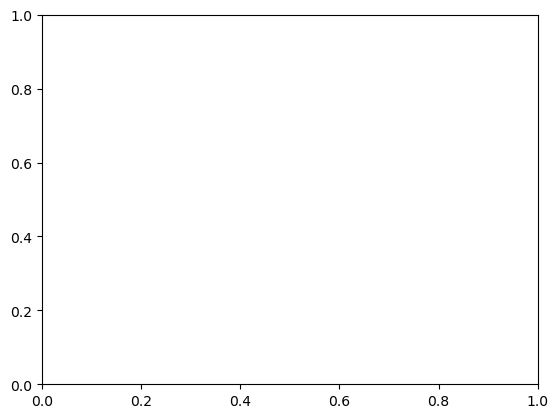

In [ ]:
import matplotlib.pyplot as plt

# Get the temperatures and average energy changes
temperatures = list(results_dict.keys())
average_energy_changes = [np.mean(np.abs(results_dict[T]['accepted_energy_changes'])) for T in temperatures]

# Filter out the non-zero energy changes
non_zero_average_energy_changes = [change for change in average_energy_changes if change != 0]

# Plot the temperature against the average change in energy
plt.plot(temperatures, non_zero_average_energy_changes)
plt.xlabel('Temperature')
plt.ylabel('Average Change in Energy')
plt.title('Temperature vs Average Change in Energy')
plt.show()


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

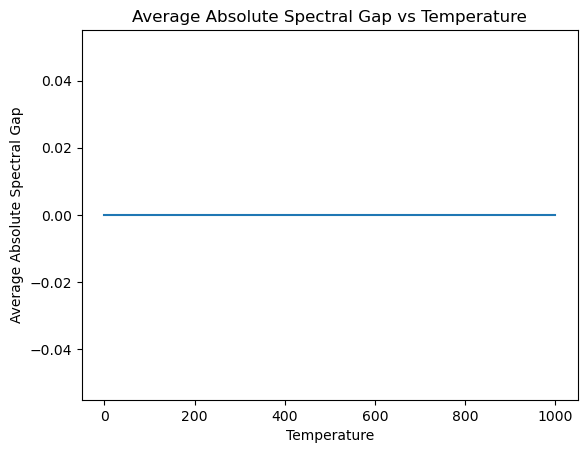

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store the average absolute spectral gap and temperatures
avg_abs_spectral_gap = []
temperatures = []

# Iterate over the keys (temperatures) in the results_dict dictionary
for T in results_dict.keys():
    # Get the accepted energy changes for the current temperature
    accepted_energy_changes = results_dict[T]['accepted_energy_changes']

    # Compute the average absolute spectral gap for the current temperature
    avg_gap = np.mean(np.abs(accepted_energy_changes))

    # Append the average absolute spectral gap and temperature to the respective lists
    avg_abs_spectral_gap.append(avg_gap)
    temperatures.append(T)

# Plot the average absolute spectral gap against temperature
plt.plot(temperatures, avg_abs_spectral_gap)
plt.xlabel('Temperature')
plt.ylabel('Average Absolute Spectral Gap')
plt.title('Average Absolute Spectral Gap vs Temperature')
plt.show()


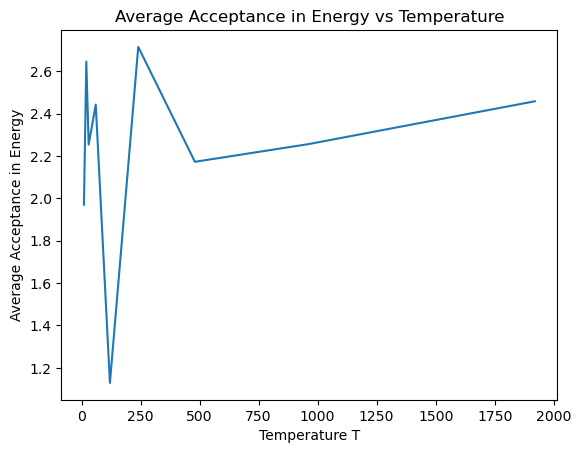

In [ ]:
# Extract the temperature and average acceptance in energy from the results dictionary
average_acceptance_energies = [np.mean(np.abs(results_dict[T]['accepted_energies'])) for T in temperatures]

# Plot the average acceptance in energy against the temperature
plt.plot(temperatures, average_acceptance_energies)
plt.xlabel('Temperature T')
plt.ylabel('Average Acceptance in Energy')
plt.title('Average Acceptance in Energy vs Temperature')
plt.show()


## Individual trials

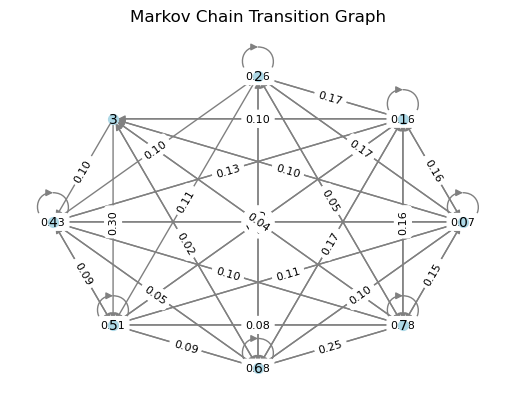

In [ ]:
make_markov_chain(accepted_states_int, num_qubits)

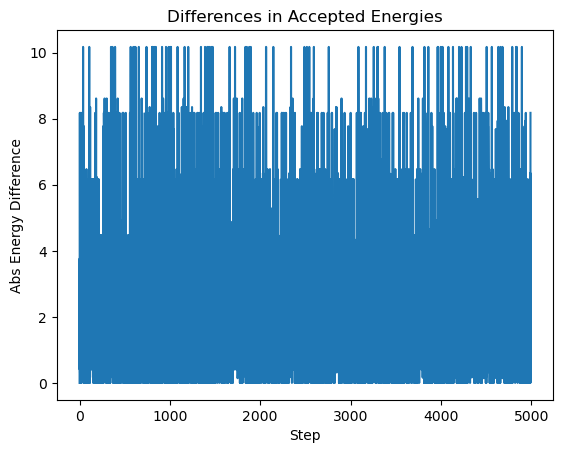

In [ ]:
# Plot the differences in accepted_energies
differences = np.abs(np.diff(accepted_energies))
plt.plot(range(len(differences)), differences)
plt.xlabel('Step')
plt.ylabel('Abs Energy Difference')
plt.title('Differences in Accepted Energies')
plt.show()


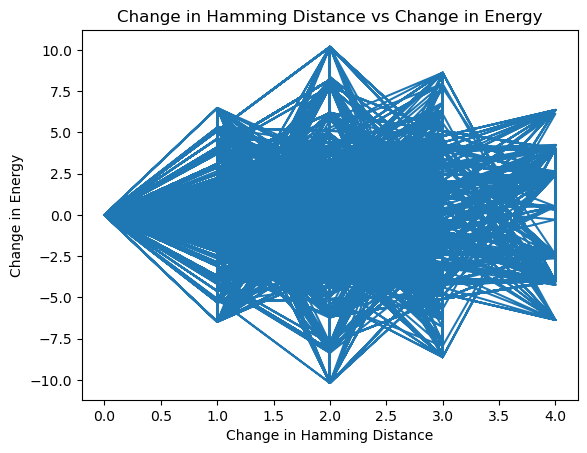

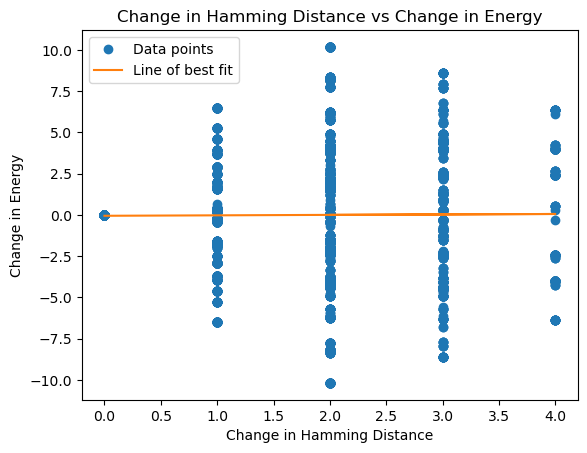

In [ ]:
# Compute the change in Hamming distance between consecutive accepted states
hamming_distances = [compute_hamming_distance(accepted_states[i], accepted_states[i+1]) for i in range(len(accepted_states)-1)]

# Plot the change in Hamming distance against the change in energy
plt.plot(hamming_distances, np.diff(accepted_energies))
plt.xlabel('Change in Hamming Distance')
plt.ylabel('Change in Energy')
plt.title('Change in Hamming Distance vs Change in Energy')
plt.show()
# Compute the change in Hamming distance between consecutive accepted states
hamming_distances = [compute_hamming_distance(accepted_states[i], accepted_states[i+1]) for i in range(len(accepted_states)-1)]

# Compute the change in energy
change_in_energy = np.diff(accepted_energies)

# Fit a polynomial of degree 1 to the data points
coefficients = np.polyfit(hamming_distances, change_in_energy, 1)

# Generate the line of best fit using the polynomial coefficients
line_of_best_fit = np.polyval(coefficients, hamming_distances)

# Plot the change in Hamming distance against the change in energy with the line of best fit
plt.plot(hamming_distances, change_in_energy, 'o', label='Data points')
plt.plot(hamming_distances, line_of_best_fit, label='Line of best fit')
plt.xlabel('Change in Hamming Distance')
plt.ylabel('Change in Energy')
plt.title('Change in Hamming Distance vs Change in Energy')
plt.legend()
plt.show()

# Classical monte carlo

In [ ]:
def flip_single_bit(state):
    """
    This function flips a single bit in the given state at random.
    Args:
        state (numpy.ndarray): The state to be modified.
        indices (range): The range of indices within which the bits will be randomly selected.

    Returns:
        numpy.ndarray: The modified state with the randomly selected bits flipped.
    """
    # Create a copy of the state to avoid modifying the original array
    modified_state = np.copy(state)

    # Randomly select a single index within the specified range
    selected_index = np.random.choice(len(state))

    # Flip the bit at the selected index
    modified_state[selected_index] = 1 - modified_state[selected_index]

    return modified_state


def flip_group_bits(state):
    """
    This function flips a group of bits in the given state at randomly selected indices within the specified range.

    Args:
        state (numpy.ndarray): The state to be modified.
        indices (range): The range of indices within which the bits will be randomly selected.

    Returns:
        numpy.ndarray: The modified state with the randomly selected bits flipped.
    """
    indices = range(len(state//2))

    # Create a copy of the state to avoid modifying the original array
    modified_state = np.copy(state)

    # Randomly select a subset of indices within the specified range
    selected_indices = np.random.choice(indices, size=np.random.randint(1, len(indices)+1), replace=False)

    # Flip the bits at the selected indices
    modified_state[selected_indices] = 1 - modified_state[selected_indices]

    return modified_state


In [ ]:
def classical_metropolis_hastings(initial_state, num_steps, proposal_func):
    """
    This function performs the classical Metropolis-Hastings algorithm. It starts from an initial state and performs a given number of steps. At each step, it proposes a new state using the specified proposal function and decides whether to accept or reject it based on the Metropolis-Hastings acceptance probability.

    Args:
        initial_state (numpy.ndarray): The initial state.
        num_steps (int): The number of steps to perform in the Metropolis-Hastings algorithm.
        proposal_func (function): The proposal function that generates a new state given the current state.

    Returns:
        list: A list of accepted states.
        list: A list of rejected states.
        list: A list of energies of the accepted states.
        list: A list of energies of the rejected states.
    """

    # Initialize the current state to the initial state
    current_state = initial_state

    # Initialize lists to store the accepted and rejected states and their energies
    accepted_states = []
    rejected_states = []
    accepted_energies = []
    rejected_energies = []

    # Perform the Metropolis-Hastings algorithm for the specified number of steps
    for step in range(num_steps):
        # Propose a new state using the specified proposal function
        proposed_state = proposal_func(current_state)

        # Compute the energy of the current state
        current_energy = H_energy(current_state, H, num_qubits)

        # Compute the energy of the proposed state
        proposed_energy = H_energy(proposed_state, H, num_qubits)

        # Compute the energy difference between the proposed state and the current state
        energy_difference = compute_scaled_energy_difference(current_state, proposed_state, H, num_qubits, beta)


        # Compute the Metropolis-Hastings acceptance probability
        acceptance_prob = min(1, np.exp(-energy_difference))

        # Decide whether to accept or reject the proposed state
        if np.random.rand() < acceptance_prob:
            # If the proposed state is accepted, update the current state and add the proposed state and its energy to the lists of accepted states and energies
            current_state = proposed_state
            accepted_states.append(proposed_state)
            accepted_energies.append(proposed_energy)
        else:
            # If the proposed state is rejected, add the proposed state and its energy to the lists of rejected states and energies
            rejected_states.append(proposed_state)
            rejected_energies.append(proposed_energy)
            accepted_states.append(current_state)
            accepted_energies.append(current_energy)

    # Return the lists of accepted and rejected states and their energies
    return accepted_states, rejected_states, accepted_energies, rejected_energies


## Group bit flip

In [ ]:
H = get_ising_hamiltonian(J, h, num_qubits)
num_steps = 1000
# proposal_func = flip_single_bit
proposal_func = flip_group_bits
accepted_states, rejected_states, accepted_energies, rejected_energies = classical_metropolis_hastings(initial_state, num_steps, proposal_func)
accepted_states_int = [binary_to_int([int(bit) for bit in state]) for state in accepted_states]
rejected_states_int = [binary_to_int([int(bit) for bit in state]) for state in rejected_states]

In [ ]:
flip_group_state_data = {'accepted_states' : accepted_states, 'rejected_states' : rejected_states, 'accepted_energies' : accepted_energies, 'rejected_energies' : rejected_energies}

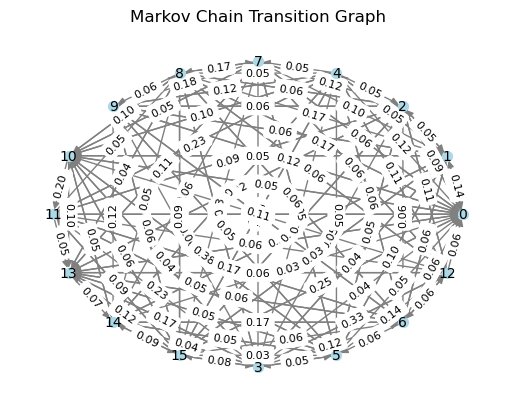

In [ ]:
# Convert the list of accepted states to a numpy array
accepted_states_array = np.array(accepted_states_int)

# Calculate the number of unique states
num_unique_states = len(np.unique(accepted_states_array))

# Create a transition matrix of size (num_unique_states, num_unique_states) initialized with zeros
transition_matrix = np.zeros((2**num_qubits, 2**num_qubits))

# Loop over each accepted state
for i in range(len(accepted_states_array) - 1):
    # Get the current state and the next state
    current_state = accepted_states_array[i]
    next_state = accepted_states_array[i + 1]

    # Increment the corresponding entry in the transition matrix
    transition_matrix[current_state, next_state] += 1

# Normalize the transition matrix by dividing each row by its sum
transition_matrix_normalized = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# Create a directed graph
G = nx.DiGraph()

# Loop over each non-zero entry in the transition matrix
for i, row in enumerate(transition_matrix_normalized):
    for j, weight in enumerate(row):
        if weight != 0:
            # Add an edge from the current state to the next state with the normalized weight
            G.add_edge(i, j, weight=weight)

# Plot the graph in the style of a Markov chain
pos = nx.circular_layout(G)
labels = {state: str(state) for state in G.nodes()}
edge_labels = {(u, v): f"{weight:.2f}" for u, v, weight in G.edges(data='weight')}
nx.draw_networkx(G, pos, labels=labels, node_color='lightblue', node_size=50, font_size=10, edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Markov Chain Transition Graph")
plt.axis('off')
plt.show()


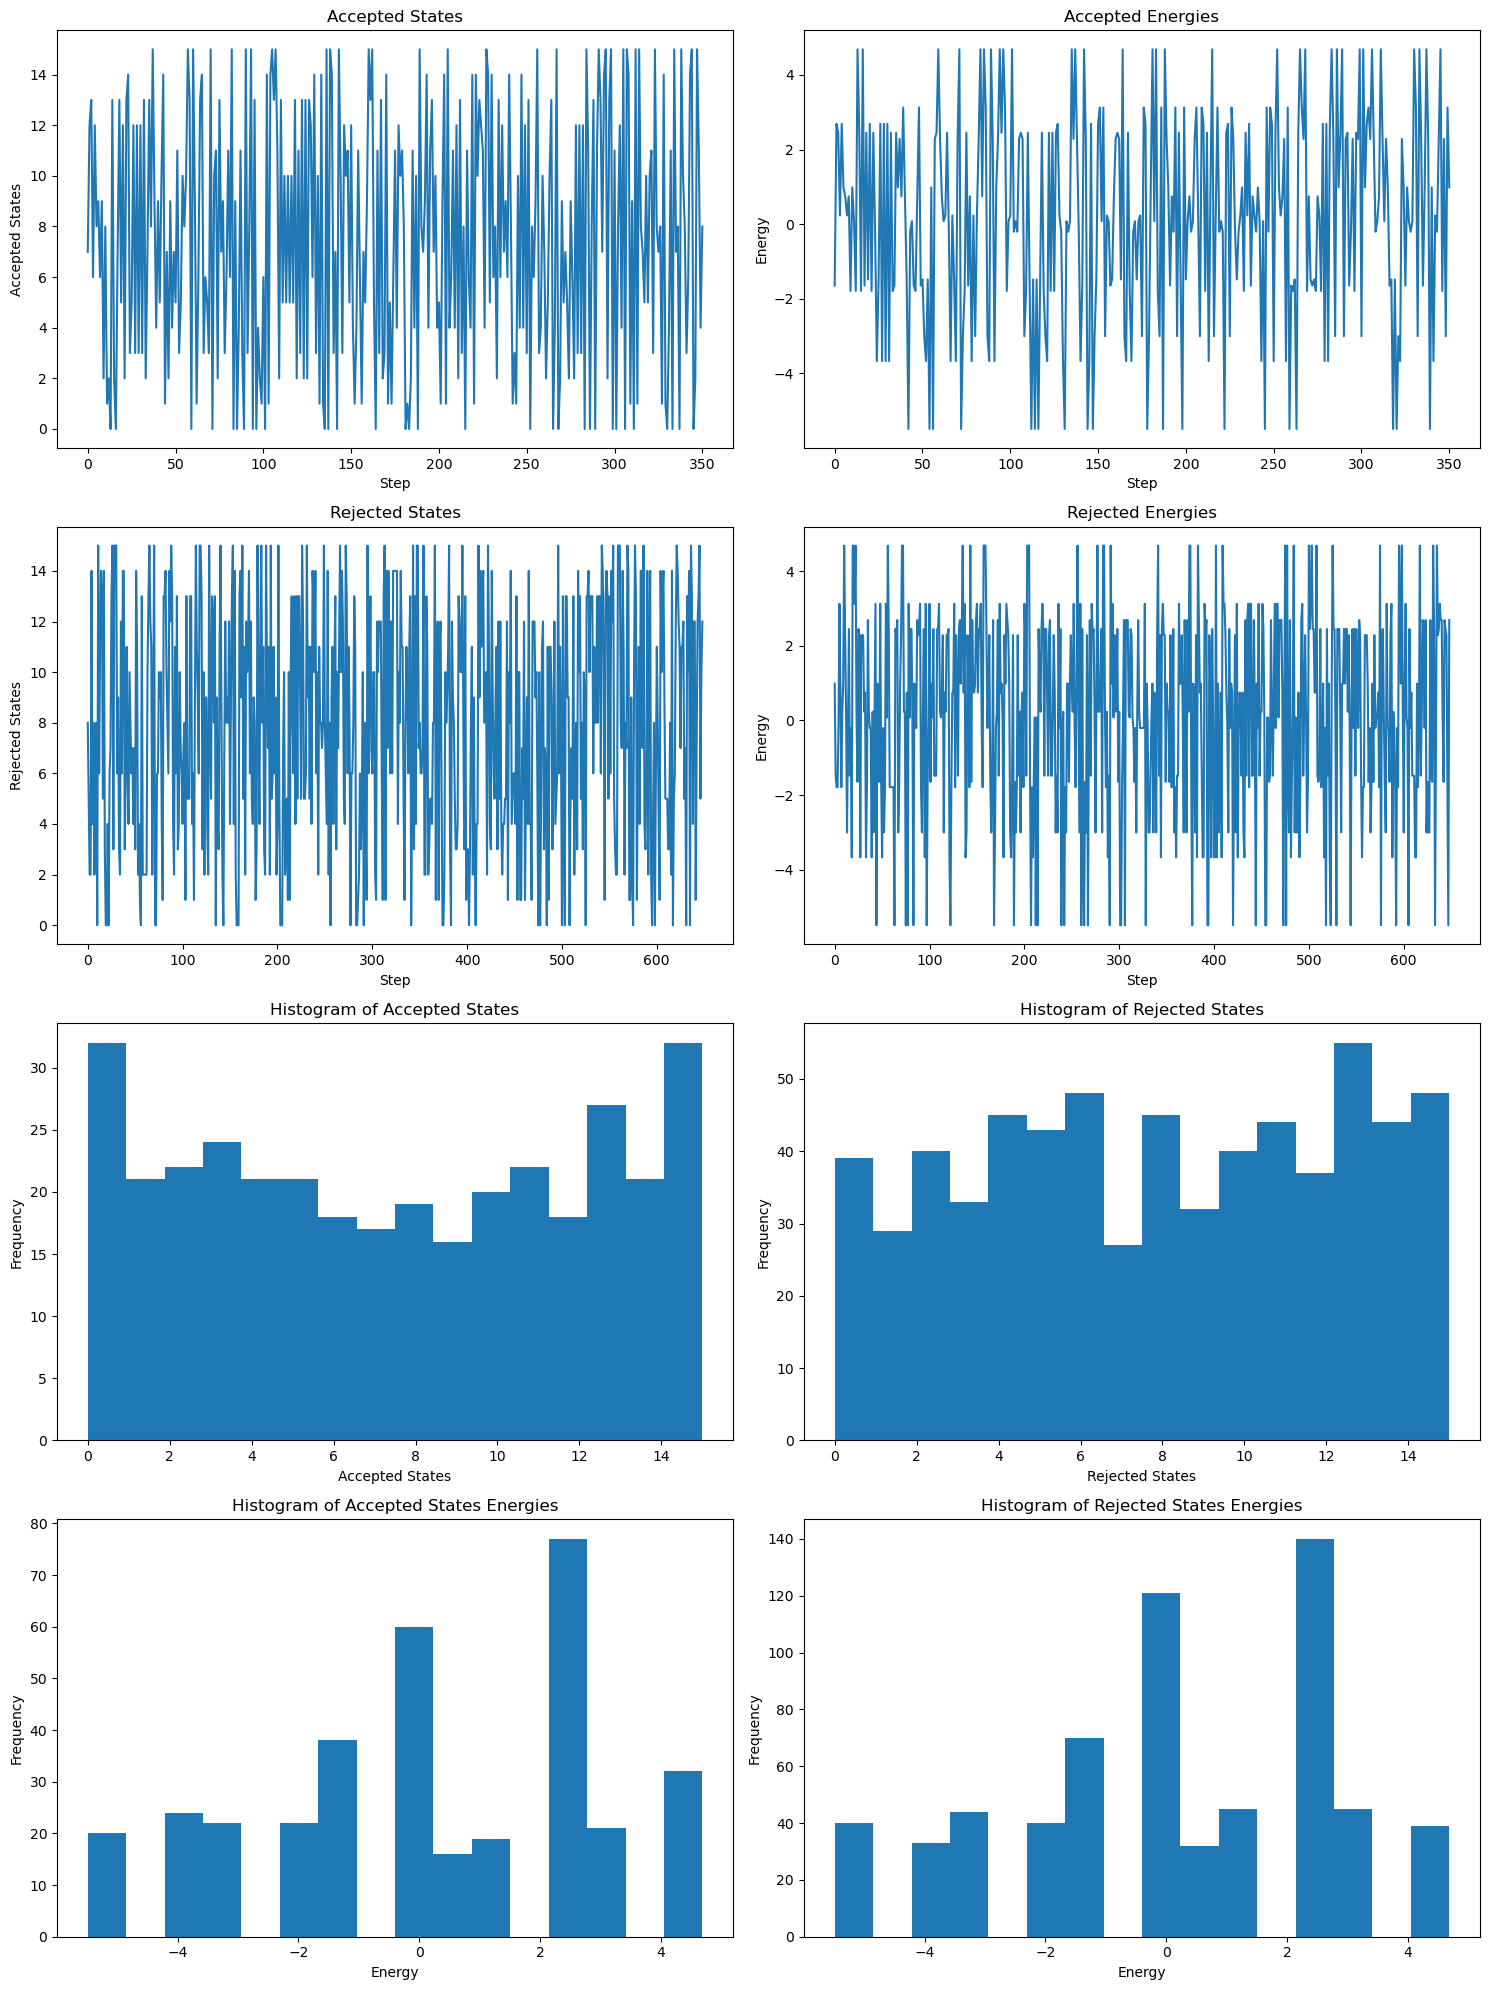

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

# Plot accepted states
axs[0, 0].plot(range(len(accepted_states_int)), accepted_states_int)
axs[0, 0].set(xlabel='Step', ylabel='Accepted States', title='Accepted States')

# Plot accepted energies
axs[0, 1].plot(range(len(accepted_energies)), accepted_energies)
axs[0, 1].set(xlabel='Step', ylabel='Energy', title='Accepted Energies')

# Plot rejected states
axs[1, 0].plot(range(len(rejected_states_int)), rejected_states_int)
axs[1, 0].set(xlabel='Step', ylabel='Rejected States', title='Rejected States')

# Plot rejected energies
axs[1, 1].plot(range(len(rejected_states_int)), rejected_energies)
axs[1, 1].set(xlabel='Step', ylabel='Energy', title='Rejected Energies')

# Plot histogram of accepted states
axs[2, 0].hist(accepted_states_int, bins=2**num_qubits)
axs[2, 0].set(xlabel='Accepted States', ylabel='Frequency', title='Histogram of Accepted States')

# Plot histogram of rejected states
axs[2, 1].hist(rejected_states_int, bins=2**num_qubits)
axs[2, 1].set(xlabel='Rejected States', ylabel='Frequency', title='Histogram of Rejected States')

# Plot histogram of accepted states energies
axs[3, 0].hist(accepted_energies, bins=2**num_qubits)
axs[3, 0].set(xlabel='Energy', ylabel='Frequency', title='Histogram of Accepted States Energies')

# Plot histogram of rejected states energies
axs[3, 1].hist(rejected_energies, bins=2**num_qubits)
axs[3, 1].set(xlabel='Energy', ylabel='Frequency', title='Histogram of Rejected States Energies')

# Adjust the space between plots
plt.tight_layout()
plt.show()

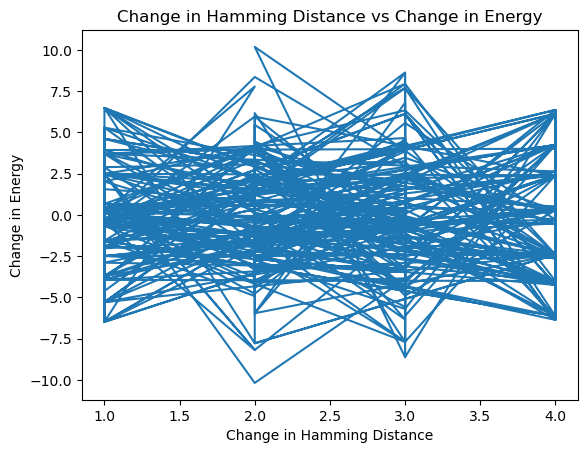

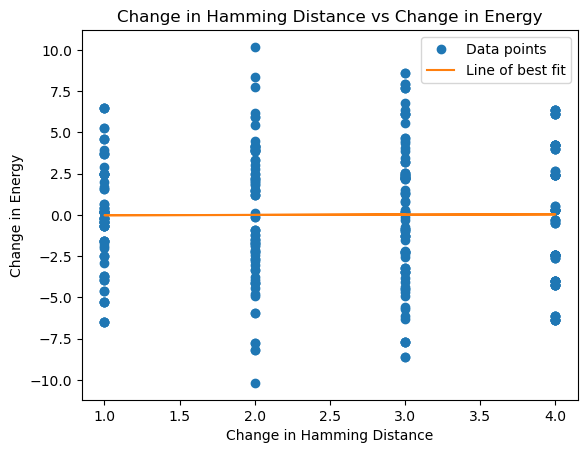

In [ ]:
def compute_hamming_distance(state1, state2):
    """
    This function computes the Hamming distance between two binary states.

    Args:
        state1 (array): The first binary state.
        state2 (array): The second binary state.

    Returns:
        int: The Hamming distance between the two states.
    """
    return np.sum(state1 != state2)

# Compute the change in Hamming distance between consecutive accepted states
hamming_distances = [compute_hamming_distance(accepted_states[i], accepted_states[i+1]) for i in range(len(accepted_states)-1)]

# Plot the change in Hamming distance against the change in energy
plt.plot(hamming_distances, np.diff(accepted_energies))
plt.xlabel('Change in Hamming Distance')
plt.ylabel('Change in Energy')
plt.title('Change in Hamming Distance vs Change in Energy')
plt.show()
# Compute the change in Hamming distance between consecutive accepted states
hamming_distances = [compute_hamming_distance(accepted_states[i], accepted_states[i+1]) for i in range(len(accepted_states)-1)]

# Compute the change in energy
change_in_energy = np.diff(accepted_energies)

# Fit a polynomial of degree 1 to the data points
coefficients = np.polyfit(hamming_distances, change_in_energy, 1)

# Generate the line of best fit using the polynomial coefficients
line_of_best_fit = np.polyval(coefficients, hamming_distances)

# Plot the change in Hamming distance against the change in energy with the line of best fit
plt.plot(hamming_distances, change_in_energy, 'o', label='Data points')
plt.plot(hamming_distances, line_of_best_fit, label='Line of best fit')
plt.xlabel('Change in Hamming Distance')
plt.ylabel('Change in Energy')
plt.title('Change in Hamming Distance vs Change in Energy')
plt.legend()
plt.show()


Eigenvalues: 
((1.0000000000000007+0j), (0.9999999999999996+0j))
((0.2696470764778274+0.044622743814455336j), (0.2696470764778274+0.0446227438144553j))
((0.2696470764778274-0.044622743814455336j), (0.2696470764778274-0.0446227438144553j))
((-0.4169740058555919+0j), (-0.4169740058555915+0j))
((-0.2672549533100098+0.15838833694871782j), (-0.26725495331001015+0.15838833694871782j))
((-0.2672549533100098-0.15838833694871782j), (-0.26725495331001015-0.15838833694871782j))
((-0.31878824460419375+0j), (-0.318788244604195+0j))
((-0.2461214620691326+0.10062638703968724j), (-0.24612146206913244+0.10062638703968715j))
((-0.2461214620691326-0.10062638703968724j), (-0.24612146206913244-0.10062638703968715j))
((-0.1510929802483828+0j), (0.1621044210640229+0.05811343564651694j))
((0.162104421064023+0.05811343564651678j), (0.1621044210640229-0.05811343564651694j))
((0.162104421064023-0.05811343564651678j), (0.13677005840807444+0j))
((0.1367700584080745+0j), (-0.15109298024838266+0j))
((-0.043723713905

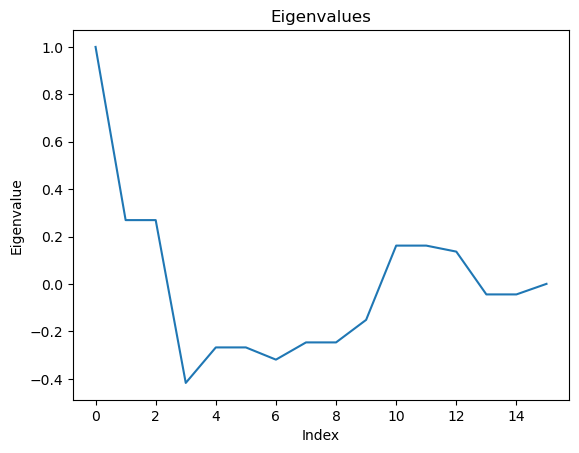

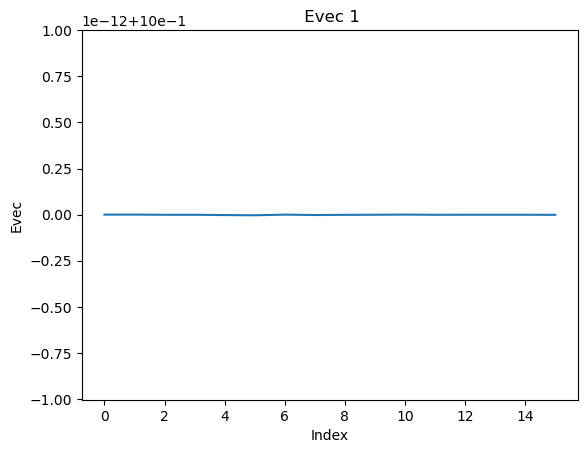

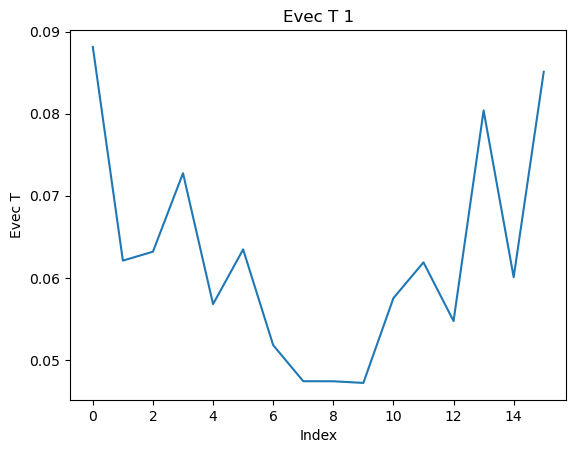

<Figure size 640x480 with 0 Axes>

In [ ]:
compute_and_plot_stationary_distribution(accepted_states_int,num_qubits)

## Single bit flip

In [ ]:
H = get_ising_hamiltonian(J, h, num_qubits)
num_steps = 1000
proposal_func = flip_single_bit
# proposal_func = flip_group_bits
accepted_states, rejected_states, accepted_energies, rejected_energies = classical_metropolis_hastings(initial_state, num_steps, proposal_func)
accepted_states_int = [binary_to_int([int(bit) for bit in state]) for state in accepted_states]
rejected_states_int = [binary_to_int([int(bit) for bit in state]) for state in rejected_states]

In [ ]:
flip_bit_state_data = {'accepted_states' : accepted_states, 'rejected_states' : rejected_states, 'accepted_energies' : accepted_energies, 'rejected_energies' : rejected_energies}

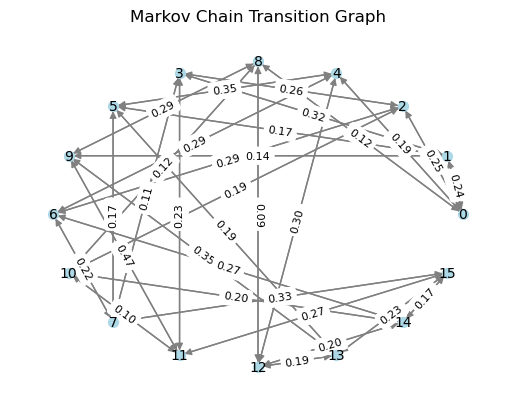

In [ ]:
# Convert the list of accepted states to a numpy array
accepted_states_array = np.array(accepted_states_int)

# Calculate the number of unique states
num_unique_states = len(np.unique(accepted_states_array))

# Create a transition matrix of size (num_unique_states, num_unique_states) initialized with zeros
transition_matrix = np.zeros((2**num_qubits, 2**num_qubits))

# Loop over each accepted state
for i in range(len(accepted_states_array) - 1):
    # Get the current state and the next state
    current_state = accepted_states_array[i]
    next_state = accepted_states_array[i + 1]

    # Increment the corresponding entry in the transition matrix
    transition_matrix[current_state, next_state] += 1

# Normalize the transition matrix by dividing each row by its sum
transition_matrix_normalized = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# Create a directed graph
G = nx.DiGraph()

# Loop over each non-zero entry in the transition matrix
for i, row in enumerate(transition_matrix_normalized):
    for j, weight in enumerate(row):
        if weight != 0:
            # Add an edge from the current state to the next state with the normalized weight
            G.add_edge(i, j, weight=weight)

# Plot the graph in the style of a Markov chain
pos = nx.circular_layout(G)
labels = {state: str(state) for state in G.nodes()}
edge_labels = {(u, v): f"{weight:.2f}" for u, v, weight in G.edges(data='weight')}
nx.draw_networkx(G, pos, labels=labels, node_color='lightblue', node_size=50, font_size=10, edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Markov Chain Transition Graph")
plt.axis('off')
plt.show()


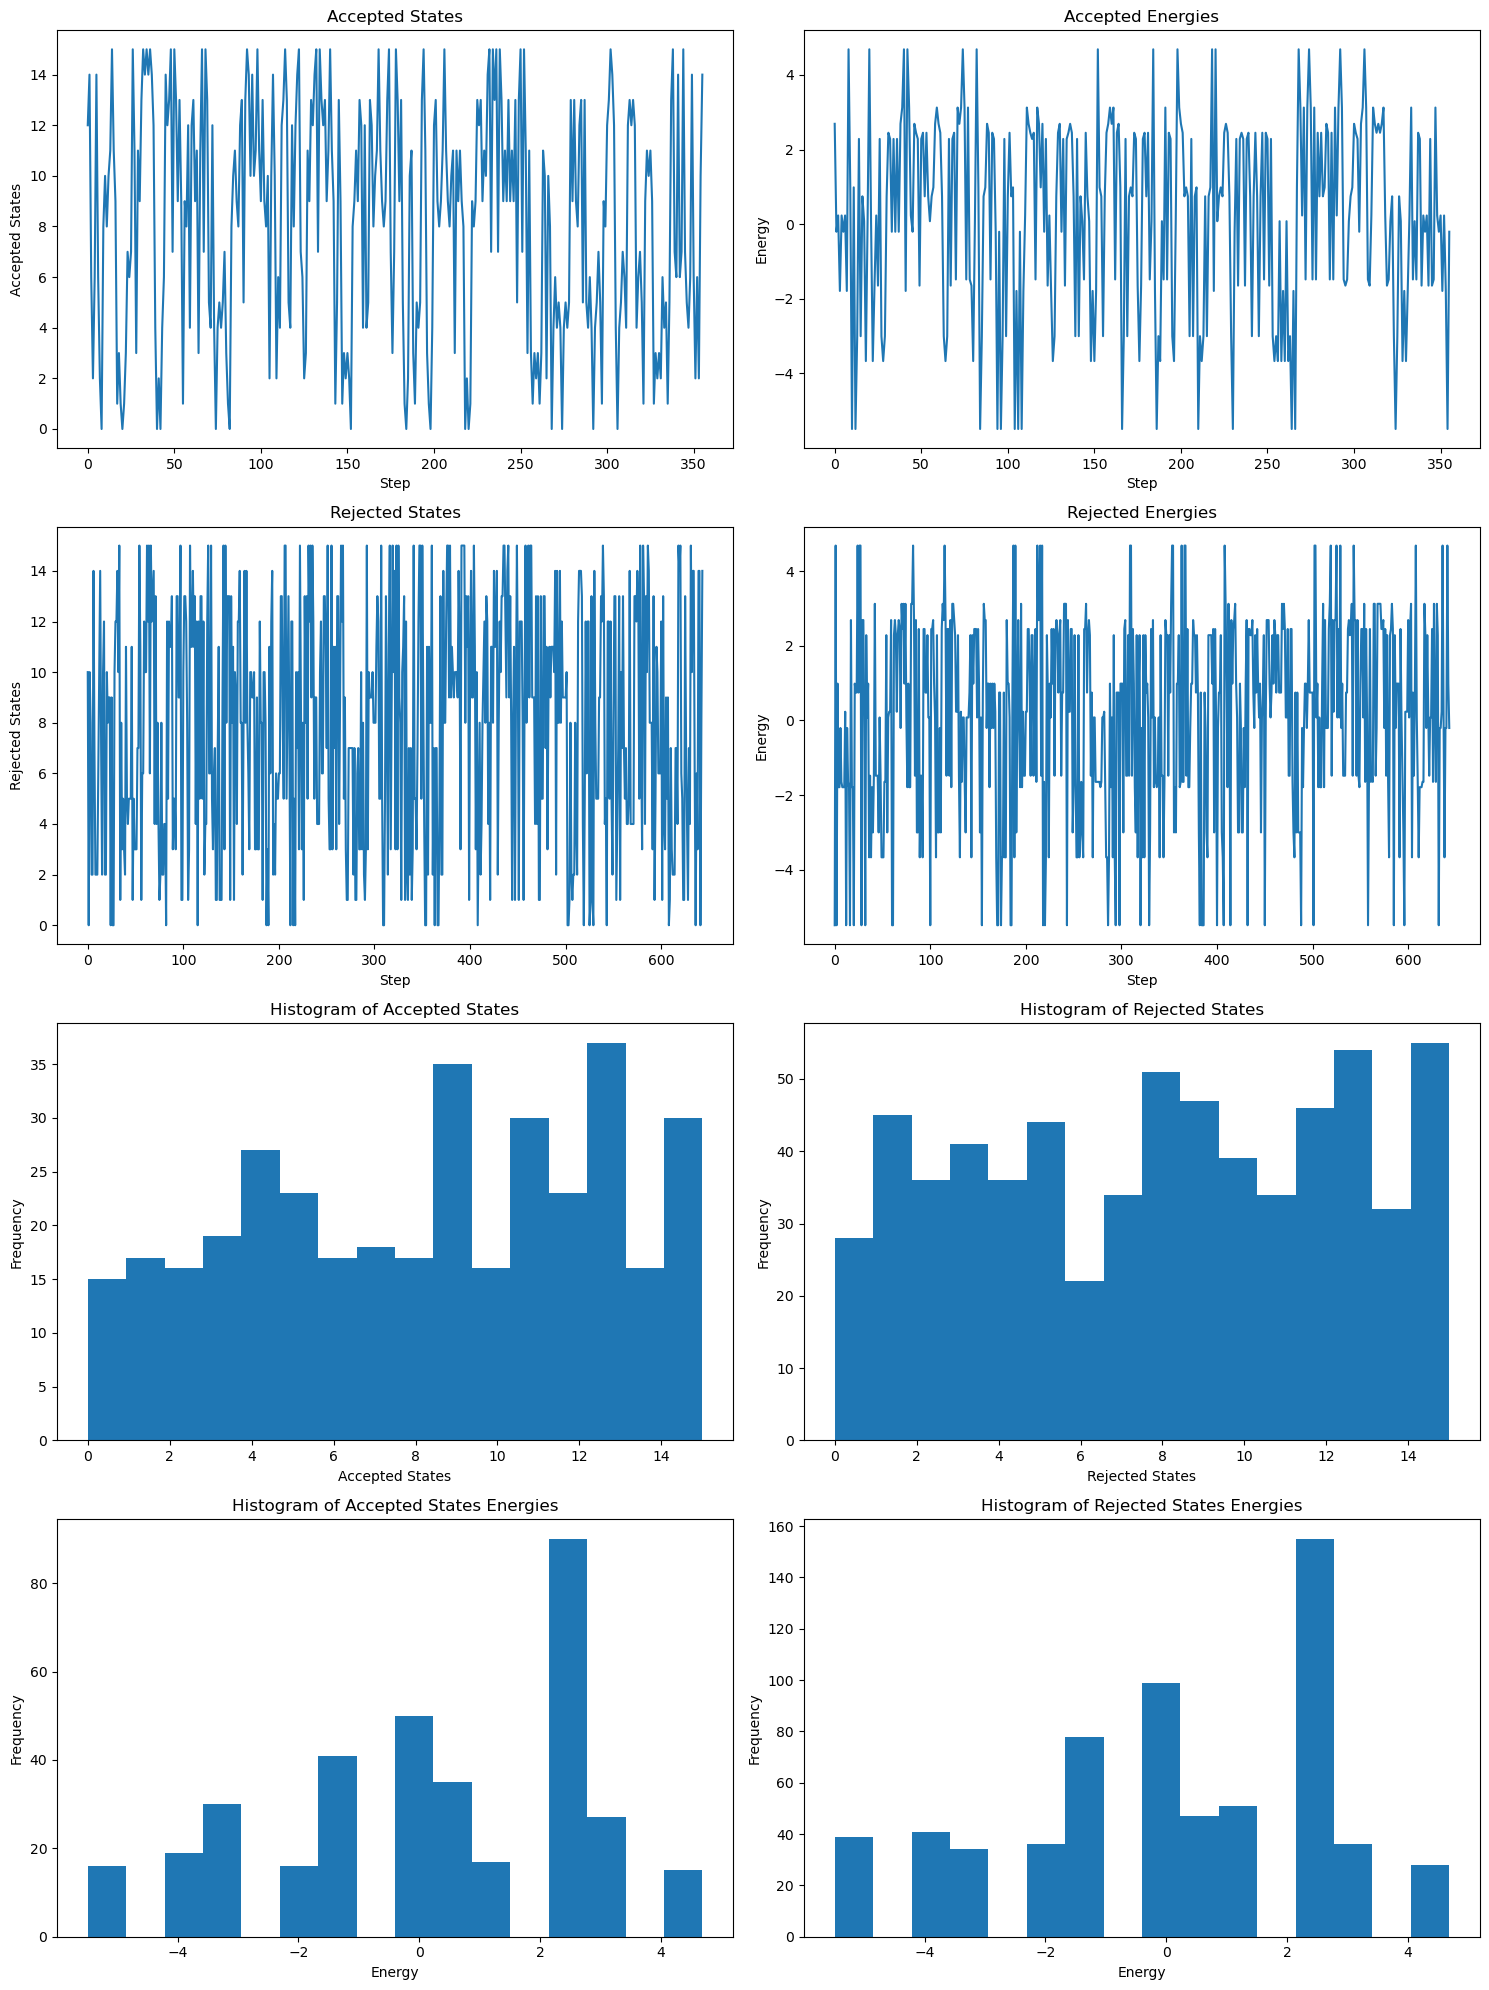

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

# Plot accepted states
axs[0, 0].plot(range(len(accepted_states_int)), accepted_states_int)
axs[0, 0].set(xlabel='Step', ylabel='Accepted States', title='Accepted States')

# Plot accepted energies
axs[0, 1].plot(range(len(accepted_energies)), accepted_energies)
axs[0, 1].set(xlabel='Step', ylabel='Energy', title='Accepted Energies')

# Plot rejected states
axs[1, 0].plot(range(len(rejected_states_int)), rejected_states_int)
axs[1, 0].set(xlabel='Step', ylabel='Rejected States', title='Rejected States')

# Plot rejected energies
axs[1, 1].plot(range(len(rejected_states_int)), rejected_energies)
axs[1, 1].set(xlabel='Step', ylabel='Energy', title='Rejected Energies')

# Plot histogram of accepted states
axs[2, 0].hist(accepted_states_int, bins=2**num_qubits)
axs[2, 0].set(xlabel='Accepted States', ylabel='Frequency', title='Histogram of Accepted States')

# Plot histogram of rejected states
axs[2, 1].hist(rejected_states_int, bins=2**num_qubits)
axs[2, 1].set(xlabel='Rejected States', ylabel='Frequency', title='Histogram of Rejected States')

# Plot histogram of accepted states energies
axs[3, 0].hist(accepted_energies, bins=2**num_qubits)
axs[3, 0].set(xlabel='Energy', ylabel='Frequency', title='Histogram of Accepted States Energies')

# Plot histogram of rejected states energies
axs[3, 1].hist(rejected_energies, bins=2**num_qubits)
axs[3, 1].set(xlabel='Energy', ylabel='Frequency', title='Histogram of Rejected States Energies')

# Adjust the space between plots
plt.tight_layout()
plt.show()

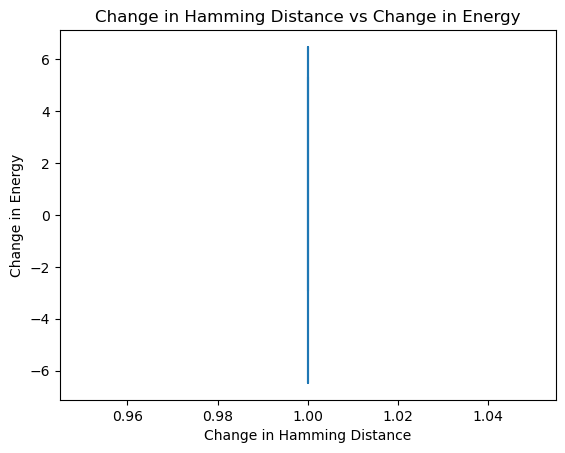

/var/folders/jn/j9nggrw13g9gcrkh0hbk4mnc0000gn/T/ipykernel_4720/1737500812.py:30: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(hamming_distances, change_in_energy, 1)


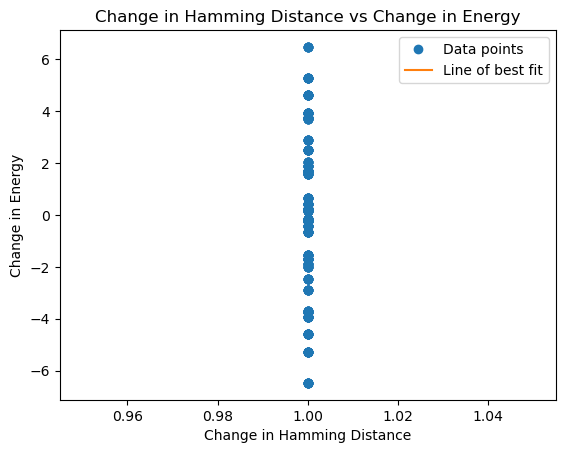

In [ ]:
def compute_hamming_distance(state1, state2):
    """
    This function computes the Hamming distance between two binary states.

    Args:
        state1 (array): The first binary state.
        state2 (array): The second binary state.

    Returns:
        int: The Hamming distance between the two states.
    """
    return np.sum(state1 != state2)

# Compute the change in Hamming distance between consecutive accepted states
hamming_distances = [compute_hamming_distance(accepted_states[i], accepted_states[i+1]) for i in range(len(accepted_states)-1)]

# Plot the change in Hamming distance against the change in energy
plt.plot(hamming_distances, np.diff(accepted_energies))
plt.xlabel('Change in Hamming Distance')
plt.ylabel('Change in Energy')
plt.title('Change in Hamming Distance vs Change in Energy')
plt.show()
# Compute the change in Hamming distance between consecutive accepted states
hamming_distances = [compute_hamming_distance(accepted_states[i], accepted_states[i+1]) for i in range(len(accepted_states)-1)]

# Compute the change in energy
change_in_energy = np.diff(accepted_energies)

# Fit a polynomial of degree 1 to the data points
coefficients = np.polyfit(hamming_distances, change_in_energy, 1)

# Generate the line of best fit using the polynomial coefficients
line_of_best_fit = np.polyval(coefficients, hamming_distances)

# Plot the change in Hamming distance against the change in energy with the line of best fit
plt.plot(hamming_distances, change_in_energy, 'o', label='Data points')
plt.plot(hamming_distances, line_of_best_fit, label='Line of best fit')
plt.xlabel('Change in Hamming Distance')
plt.ylabel('Change in Energy')
plt.title('Change in Hamming Distance vs Change in Energy')
plt.legend()
plt.show()


Eigenvalues: 
((-0.9999999999999997+0j), (0.999999999999998+0j))
((0.9999999999999998+0j), (-1.0000000000000022+0j))
((-0.55536754174021+0.026064035264666215j), (0.5553675417402097+0.026064035264665646j))
((-0.55536754174021-0.026064035264666215j), (0.5553675417402097-0.026064035264665646j))
((-0.5106075921721931+0j), (0.5106075921721966+0j))
((0.5553675417402112+0.02606403526466559j), (0.37670556296811436+0j))
((0.5553675417402112-0.02606403526466559j), (-0.5553675417402094+0.02606403526466583j))
((0.5106075921721961+0j), (-0.5553675417402094-0.02606403526466583j))
((-0.3767055629681139+0j), (-0.5106075921721964+0j))
((0.3767055629681144+0j), (-0.3767055629681138+0j))
((-0.055053164055774345+0.06754633414379844j), (0.05505316405577451+0.0675463341437985j))
((-0.055053164055774345-0.06754633414379844j), (0.05505316405577451-0.0675463341437985j))
((0.05505316405577447+0.06754633414379851j), (-0.05505316405577458+0.06754633414379844j))
((0.05505316405577447-0.06754633414379851j), (-0.055

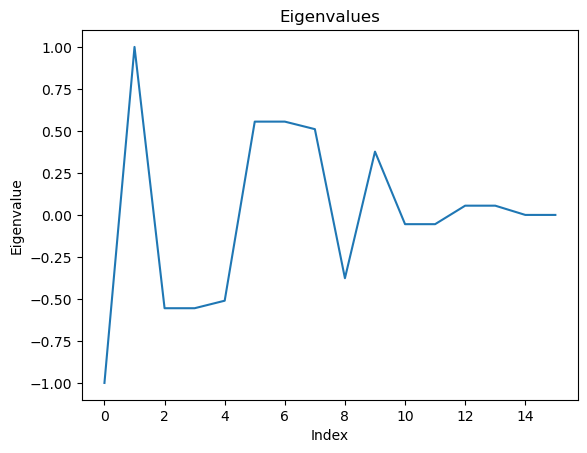

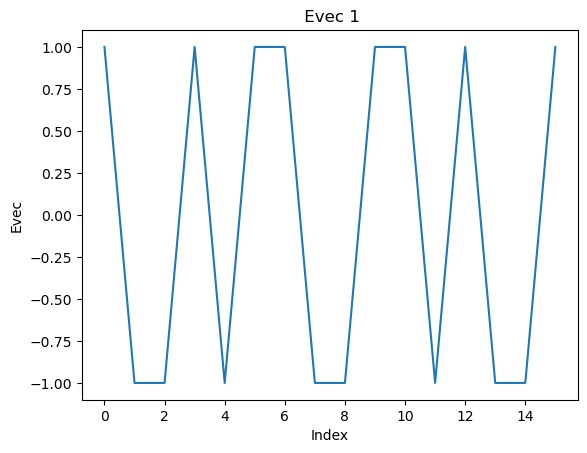

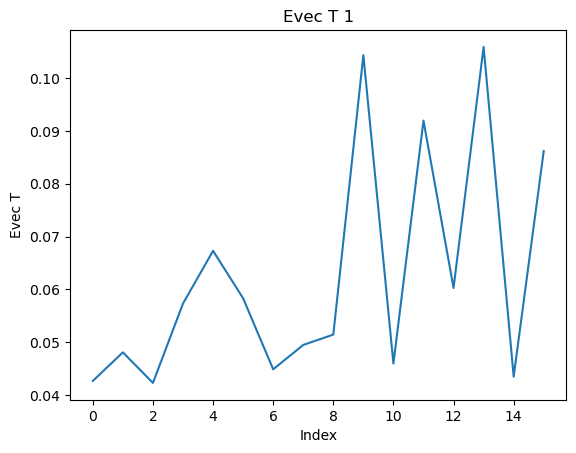

<Figure size 640x480 with 0 Axes>

In [ ]:
compute_and_plot_stationary_distribution(accepted_states_int,num_qubits)

# Inverse VQE approach

In [46]:
num_qubits = 4
# Initialize the initial state to be the ground state of the first qubit
initial_state = np.zeros(num_qubits)
initial_state[0] = 1
dev = qml.device('default.qubit', wires=num_qubits, shots=1)
# Randomly initialize the magnetic field strengths for the Ising model
h = np.random.normal(0, 1, num_qubits)

J = np.zeros((num_qubits, num_qubits))
for i in range(num_qubits):
        J[i, (i+1) % num_qubits] = np.random.normal(0, 1)

H = get_ising_hamiltonian(J, h, num_qubits)

# Set the number of steps and the temperature for the Metropolis-Hastings algorithm
R = 4
# w = 2
# beta = 0.1

alpha = 1/np.sqrt(2)
# GAMMA = range(0.26,0.6,10)
dt = np.random.uniform(2,20)/R
gamma = np.random.uniform(0.25,0.6)
a = np.ones(num_qubits) * gamma * dt
b = - np.ones(num_qubits) * (1 - gamma) * alpha * h * dt
# Randomly initialize parameters for the interaction terms in the Hamiltonian
theta = -2*(1-gamma)*alpha*J

In [47]:
@qml.qnode(dev)
def TS_var_ansatz(initial_state, theta, num_qubits):
    """
    This function defines the variational ansatz for the VQE algorithm.

    Args:
        params (array): The parameters of the ansatz.
        wires (int): The number of qubits in the system.

    Returns:
        None
    """

    # Apply a layer of Hadamard gates to all qubits
    qml.Hadamard(wires=num_qubits)

    # Apply a layer of parametrized RX gates to all qubits
    for i in range(num_qubits):
        qml.RX(theta[i], wires=i)

    # Apply a layer of parametrized RY gates to all qubits
    for i in range(num_qubits):
        qml.RY(theta[i + num_qubits], wires=i)

    # Apply a layer of parametrized RZ gates to all qubits
    for i in range(num_qubits):
        qml.RZ(theta[i + 2 * num_qubits], wires=i)

    # Measure the state of all qubits using the PauliZ operator.
    # The measurement results are returned as a 1D array.
    # return [qml.sample(qml.PauliZ(i)) for i in range(num_qubits)]

In [52]:
@qml.qnode(dev)
def T_S_evolution_error_free_train(initial_state, num_qubits, R, a, b, theta, theta_learn):
    """
    This function defines a quantum circuit for T_S evolution without errors. It uses the PennyLane library to define the quantum circuit.

    Args:
        initial_state (array): The initial state of the qubits. This should be a 1D array of length num_qubits.
        num_qubits (int): The number of qubits in the system.
        R (int): The number of iterations to perform the T_S evolution.
        a (array): The parameters for the RX gates. This should be a 1D array of length num_qubits.
        b (array): The parameters for the RZ gates. This should be a 1D array of length num_qubits.
        theta (array): The parameters for the RZ gates between CNOT gates. This should be a 2D array of size num_qubits x num_qubits.

    Returns:
        array: The measurement results of the PauliZ operators on all qubits. This is a 1D array of length num_qubits.
    """

    # Apply the initial state to the qubits using the BasisEmbedding operation.
    # This operation sets the state of each qubit to the corresponding element of the initial_state array.
    qml.BasisEmbedding(initial_state, wires=range(num_qubits))

    # Perform the T_S evolution for R iterations.
    for r in range(R):
        # Apply RX and RZ gates to the first half of the qubits.
        # The parameters for the gates are taken from the a and b arrays.
        for w in range(num_qubits//2):
            qml.RX(2*a[w], wires=w)
            qml.RZ(2*b[w], wires=w)

        # Apply a sequence of CNOT and RZ gates to pairs of qubits.
        # The pairs of qubits are chosen such that the first qubit in each pair is even and the second qubit is the next one in the sequence.
        for w in range(num_qubits//2):
            qml.CNOT(wires=[2*w, 2*w+1])
            qml.RZ(theta[2*w, 2*w+1], wires=2*w+1)
            qml.CNOT(wires=[2*w, 2*w+1])

        # Apply a sequence of CNOT and RZ gates to pairs of qubits.
        # The pairs of qubits are chosen such that the first qubit in each pair is odd and the second qubit is the next one in the sequence.
        for w in range(num_qubits//2):
            qml.CNOT(wires=[(2*w+1) % num_qubits, (2*w+2) % num_qubits])
            qml.RZ(theta[(2*w+1) % num_qubits, (2*w+2) % num_qubits], wires=(2*w+2) % num_qubits)
            qml.CNOT(wires=[(2*w+1) % num_qubits, (2*w+2) % num_qubits])

        # Apply RX and RZ gates to all the qubits.
        # The parameters for the gates are taken from the a and b arrays.
        for w in range(num_qubits):
            qml.RX(2*a[w], wires=w)
            qml.RZ(2*b[w], wires=w)

    # Measure the state of all qubits using the PauliZ operator.
    # The measurement results are returned as a 1D array.
    # return [qml.sample(qml.PauliZ(i)) for i in range(num_qubits)]


    # Apply a layer of parametrized RX gates to all qubits
    for i in range(num_qubits):
        qml.RX(theta_learn[i], wires=i)

    # Apply a layer of parametrized RY gates to all qubits
    for i in range(num_qubits):
        qml.RY(theta_learn[i + num_qubits], wires=i)

    # Apply a layer of parametrized RZ gates to all qubits
    for i in range(num_qubits):
        qml.RZ(theta_learn[i + 2 * num_qubits], wires=i)

    return [qml.sample(qml.PauliZ(i)) for i in range(num_qubits)]

In [53]:
import numpy as np

def cost_func(theta_learn):
    random_binary_array = np.random.randint(2, size=num_qubits)
    return np.absolute(binary_to_int(T_S_evolution_error_free_train(initial_state, num_qubits, R, a, b, theta, theta_learn)) - np.array(random_binary_array))

def workflow(theta_learn,ntrials):
    opt = qml.GradientDescentOptimizer(stepsize=0.4)

    for n in range(ntrials):
        theta_learn, prev_energy = opt.step_and_cost(cost_func, theta_learn)
        print(f"--- Step: {n}, Energy: {cost_func(theta_learn):.8f}")

    return theta_learn

workflow(theta_learn = np.zeros(num_qubits*3),ntrials = 100)


ValueError: invalid literal for int() with base 2: '1-11-1'